In [131]:
import osmnx as ox
import networkx as nx

import geopandas as gpd
import pandas as pd
import numpy as np
from statistics import mean

import matplotlib.pyplot as plt
import shapely
import folium

import os

In [133]:
location = 'Richmond, California, USA'
richmond_center = [37.943882, -122.35342]

ca_teale_albers_nad83 = 'NAD_1983_California_Teale_Albers_FtUS'
nad83 = 'EPSG:4629'

wgs84 = 'EPSG:4326'
wgs84_m = 'EPSG:4798'

In [135]:
richmond_basemap = folium.Map(location = richmond_center, zoom_start = 12, width = '50%', height = '50%', tiles = 'OpenStreetMap')

#richmond_basemap

In [136]:
def plot_gdf_with_background(gdf, zoom=12, center = None):
    
    if center is not None:
        map_center = center
    else:
        map_center_lon = gdf['geometry'].x.mean()
        map_center_lat = gdf['geometry'].y.mean()
        map_center = [map_center_lat, map_center_lon]
    
    map_with_background = folium.Map(map_center, zoom_start = zoom, width = '50%', height = '50%', 
                                     tiles = 'OpenStreetMap')
    
    folium.GeoJson(gdf).add_to(map_with_background)
    
    return(map_with_background)

## Read in and Clean Necessary Data

In [137]:
import warnings

warnings.filterwarnings('ignore')

#graph_raw = ox.graph_from_place(location, network_type = 'drive')

graph = ox.project_graph(graph_raw, to_crs = wgs84)
graph = ox.add_edge_speeds(graph)
graph = ox.add_edge_travel_times(graph)

graph_nodes_gdf, graph_edges_gdf = ox.graph_to_gdfs(graph, nodes = True, edges = True)

#ox.plot_graph(graph)

In [139]:
hubs_path = os.path.join(os.getcwd(), 'data', 'candidate_site_campuses_2021-11-17', 'candidate_site_campuses.csv')

hubs_df_raw = pd.read_csv(hubs_path)
hubs_df_raw = hubs_df_raw.loc[hubs_df_raw['cat_site'] != 'X', ['id_site', 'SQFT_ROOF', 'LON', 'LAT']]

hubs_geom = gpd.points_from_xy(hubs_df_raw.LON, hubs_df_raw.LAT, crs = wgs84)
hubs_gdf = gpd.GeoDataFrame(hubs_df_raw, geometry = hubs_geom, crs = wgs84)

#plot_gdf_with_background(hubs_gdf, 13, richmond_center)

In [141]:
cengeos_path = os.path.join(os.getcwd(), 'data', 'bg_ca_19', 'blockgroup_CA_19.shp')

cengeos_gdf = gpd.read_file(cengeos_path)
cengeos_gdf = cengeos_gdf.to_crs(hubs_gdf.crs)

#cengeos_gdf.plot()

In [149]:
cengeos_lons = [float(intpt) for intpt in cengeos_gdf['INTPTLON']]
cengeos_lats = [float(intpt) for intpt in cengeos_gdf['INTPTLAT']]

cengeos = pd.DataFrame(cengeos_gdf[['GISJOIN', 'COUNTYFP']])
cengeos['LON'] = cengeos_lons
cengeos['LAT'] = cengeos_lats

cengeos_pt_geom = gpd.points_from_xy(x = cengeos.LON,y = cengeos.LAT, crs = wgs84)
cengeos_pt_gdf = gpd.GeoDataFrame(cengeos, geometry = cengeos_pt_geom, crs = wgs84)

#plot_gdf_with_background(cengeos_pt_gdf, 13, richmond_center)

## Restrict to Hubs within Desired Area

In [144]:
lon_max = graph_nodes_gdf['lon'].max()
lon_min = graph_nodes_gdf['lon'].min()
lon_avg = (lon_max + lon_min)/2

lat_max = graph_nodes_gdf['lat'].max()
lat_min = graph_nodes_gdf['lat'].min()
lat_avg = (lat_min + lat_max)/2

bbox_coords = [(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)]
bbox_poly = shapely.geometry.Polygon(bbox_coords)

In [146]:
hubs_gdf_bbox = hubs_gdf[hubs_gdf.within(bbox_poly)]

#plot_gdf_with_background(hubs_gdf_bbox)

In [189]:
cengeos_pt_gdf_bbox = cengeos_pt_gdf[cengeos_pt_gdf.within(bbox_poly)]

### REMOVE THE FOLLOWING LINE AFTER TESTING!!! - selecting random BGs for matrix
cengeos_pt_gdf_bbox = cengeos_pt_gdf_bbox.iloc[[0, 3, 12, 20, 48, 65], ]

#plot_gdf_with_background(cengeos_pt_gdf_bbox, center = richmond_center)

## Build Distance Matrix for Desired Area

In [190]:
matrix_dist_to_hubs = np.NaN*np.zeros((len(cengeos_gdf_bbox), len(hubs_gdf_bbox))) #what does np.zeros do?

In [191]:
cengeos_buffer = cengeos_pt_gdf_bbox.buffer(0.025)

In [192]:
n_cengeos = len(cengeos_pt_gdf_bbox)

In [232]:
for cengeo in range(0, n_cengeos):
    
    cengeo_coords = [cengeos_pt_gdf_bbox.iloc[cengeo]['geometry'].y, cengeos_pt_gdf_bbox.iloc[cengeo]['geometry'].x]
    node_origin = ox.get_nearest_node(graph, cengeo_coords, method = 'euclidean')

    cengeo_buffer = cengeos_buffer.iloc[cengeo]
    
    hubs_nearby_gdf = hubs_gdf_bbox[hubs_gdf_bbox.within(cengeo_buffer)]
    n_hubs_nearby = len(hubs_nearby_gdf)
    
    #next for loop

In [ ]:
# from shapely.geometry import box
# bbox = box(*edges_proj.unary_union.bounds)
# orig_point = bbox.centroid
# nodes_proj['x'] = nodes_proj.x.astype(float)
# maxx = nodes_proj['x'].max()
# target_loc = nodes_proj.loc[nodes_proj['x']==maxx, :]
# target_point = target_loc.geometry.values[0]
# orig_xy = (orig_point.y, orig_point.x)
# target_xy = (target_point.y, target_point.x)
 orig_node = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')
 target_node = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')
# o_closest = nodes_proj.loc[orig_node]
# t_closest = nodes_proj.loc[target_node]
# od_nodes = gpd.GeoDataFrame([o_closest, t_closest], geometry='geometry', crs=nodes_proj.crs)


 route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')


# fig, ax = ox.plot_graph_route(graph_proj, route)


[57884800, 57855558, 57855557, 57855555, 57855552, 57855551, 57855549, 57848217, 57850335, 57850334, 57872274, 57872272, 57819814, 57872270, 57814281, 57905734, 57804451, 57897364, 57905731, 57905729, 57841646, 57889488, 57905724, 57811272, 57817024, 57834012]
[57884800, 57855558, 57855557, 57855555, 57855552, 57855551, 57855549, 57848217, 57850335, 57850334, 57872274, 57872272, 57819814, 57872270, 57814281, 57905734, 57804451, 57897364, 57905731, 57905729, 57841646, 57889488, 57905724, 57811272, 57817024, 57834012]
[57884800, 57855558, 57855557, 57855555, 57855552, 57855551, 57855549, 57848217, 57850335, 57850334, 57872274, 57872272, 57819814, 57872270, 57814281, 57905734, 57804451, 57897364, 57905731, 57905729, 57841646, 57889488, 57905724, 57811272, 57817024, 57834012]
[57884800, 57855558, 57855557, 57855555, 57855552, 57855551, 57855549, 57848217, 57850335, 57850334, 57872274, 57872272, 57819814, 57872270, 57814281, 57905734, 57804451, 57897364, 57905731, 57905729, 57841646, 578894

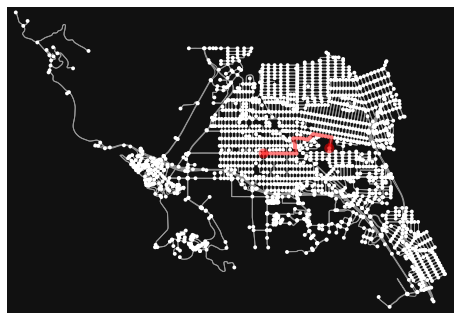

In [240]:
for hub in range(0, n_hubs_nearby):
    
    hub_geom = [hubs_nearby_gdf.iloc[hub]['geometry'].y, hubs_nearby_gdf.iloc[hub]['geometry'].x]    

    node_target = ox.get_nearest_node(graph, hub_geom, method='euclidean')
    
    route_bt_nodes = nx.shortest_path(graph, node_origin, node_target, weight='time')